# Nota Importante
O propósito deste notebook é encontrar o melhor modelo para os dados Sem Outliers, mantendo a simplicidade do LinearRegression.

Vamos usar diferentes opções de preprocessamento de dados e transformação de target para encontrar o melhor.

Nesta etapa, ainda não vamos nos preocupar com regularização de coeficiente nem com features polinomais. Faremos isso em etapas posteriores.

---

Leia o arquivo [README.md](../README.md) para detalhes sobre a base o projeto.

Leia o arquivo de [01_dicionario_de_dados.md](../referencias/01_dicionario_de_dados.md) para detalhes sobre a base.

Ao importar esse arquivo [src.graficos](./src/graficos.py), em tema seaborn é aplicado.

# Imports e configurações

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import seaborn as sns
import warnings


from sklearn.compose import ColumnTransformer # constrói um pipeline para diferentes colunas
from sklearn.linear_model import (
    LinearRegression, # modelo de regressão linear com coeficientes estimados usando o método dos mínimos quadrados
)
from sklearn.preprocessing import (  # Módulo de pré-processamento de dados
    OneHotEncoder,       # Codifica variáveis categóricas nominais, transformando-as em uma matriz binária (uma coluna para cada categoria)
    OrdinalEncoder,      # Codifica variáveis categóricas ordinais, convertendo categorias em inteiros com base na ordem
    PowerTransformer,    # Aplica uma transformação de potência para estabilizar a variância e tornar os dados mais gaussianos
    QuantileTransformer, # Realiza uma transformação baseada em quantis, escalando os dados para uma distribuição uniforme ou normal
    RobustScaler,        # Normaliza os dados utilizando estatísticas robustas (mediana e intervalo interquartil), útil para dados com outliers
    StandardScaler,      # Normaliza os dados para que tenham média zero e desvio padrão um, útil para dados normalmente distribuídos
)

from src.auxiliares import (
    fnc_dataframe_coeficientes, # função que combina os coeficientes de um gridsearch com os nomes das features em um DataFrame
    fnc_describe_numericas_personalizado, # função que retorna um dataframe com o describe() de variáveis numéricas enriquecido com colunas de tipo, ausência, variabilidade, outliers e normalidade
    fnc_exibir_dataframe_resultados, # função que exibe um DataFrame estilizado no notebook ou um DataFrame simples no console
)
from src.config import (
    DADOS_X_TEST,
    DADOS_X_TRAIN,
    DADOS_X_VALIDATION,
    DADOS_Y_TEST,
    DADOS_Y_TRAIN,
    DADOS_Y_VALIDATION,
)
from src.graficos import (
    PALETTE_TEMPERATURA,
    plot_coeficientes, # função para plotar um gráfico de barras horizontais dos coeficientes de um modelo
    plot_comparar_metricas_modelos, # função para plotar boxplots de diferentes modelos para diferentes méticas de um dataframe de resultado
    plot_residuos_estimador, # função que plota 3 gráficos de resíduos para um estimador, um histograma e dois de dispersão
)
from src.models import (
    fnc_grid_search_cv_regressor, # função para planejar modelos de regressão validação cruzada e grid search
    fnc_treinar_e_validar_modelos_regressao, # função para treinar modelos de regressão com validação cruzada usando um dicionário de regressores
)

In [2]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

# Ignorar UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

# Modelagem para melhoria do modelo da etapa 2

## Carregando os arquivos de treino/teste e validação criados na etapa 2

Origem: [01-ild-eda.ipynb](01-ild-eda.ipynb)

- `median_income`: renda mediana no grupo de blocos (em dezenas de milhares de dólares)
- `housing_median_age`: idade mediana das casas no grupo de blocos
- `total_rooms`: número cômodos no grupo de blocos
- `total_bedrooms`: número de quartos no grupo de blocos
- `population`: população do grupo de blocos
- `households`: domicílios no grupo de blocos
- `latitude`: latitude do grupo de blocos
- `longitude`: longitude do grupo de blocos
- `ocean_proximity`: proximidade do oceano
  - `NEAR BAY`: perto da baía
  - `<1H OCEAN`: a menos de uma hora do oceano
  - `INLAND`: no interior
  - `NEAR OCEAN`: perto do oceano
- `median_house_value`: valor mediano das casas no grupo de blocos (em dólares)
- `median_income_cat`: categorias baseadas no valor da mediana do salário anual -> `median_income`
- `housing_median_age_cat`: categorias baseadas no valor da mediana das idades das casas -> `housing_median_age`
- `population_cat`: categorias baseadas no tamanho da população -> `population`
- `rooms_per_household`: `total_rooms` / `households`
- `population_per_household`: `population` / `households`
- `bedrooms_per_room`: `total_bedrooms` / `total_rooms`

In [3]:
# dados já separados como X e y de treino, teste e validação
X_train = pd.read_parquet(DADOS_X_TRAIN)
y_train = pd.read_parquet(DADOS_Y_TRAIN)

print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

X_train.shape (12862, 15)
y_train.shape (12862, 1)


In [4]:
display(
    X_train.head(1),
    y_train.head(1),
)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
4816,-118.28,33.91,41,620,133,642,162,2.65,<1H OCEAN,1.5 <= x < 3,40 <= x,500 <= x < 1000,3.83,3.96,0.21


,median_house_value
4816,159600


## Definindo as estratégias para os modelos

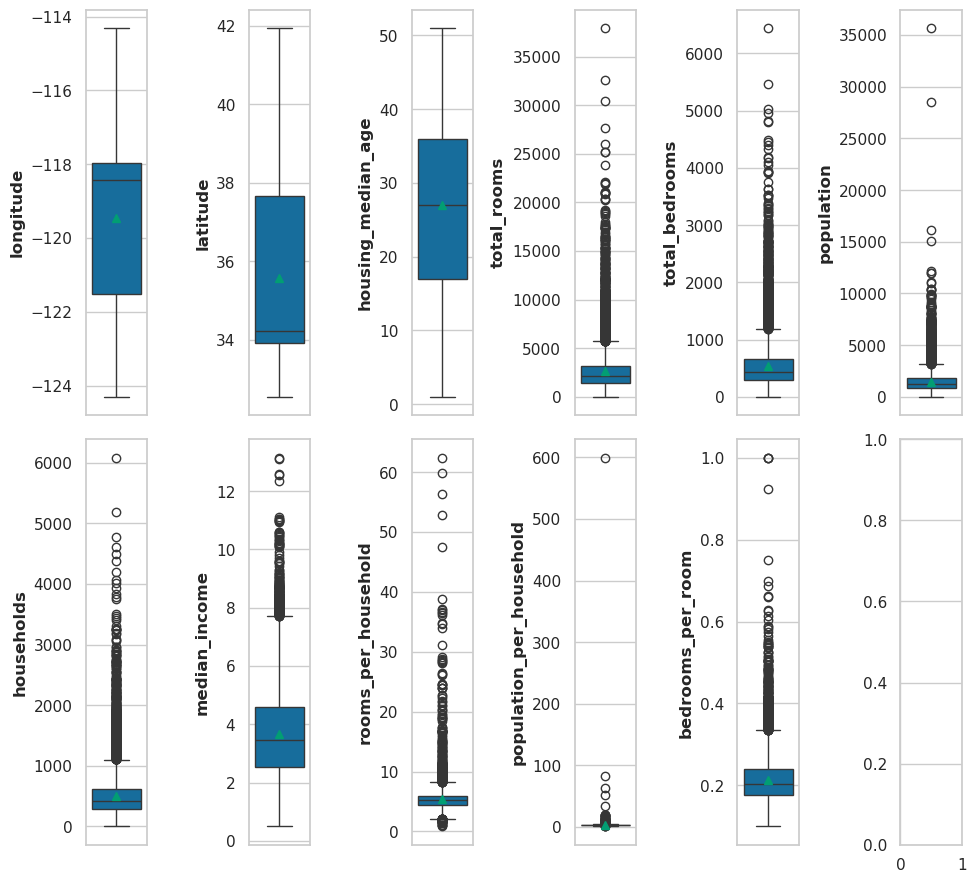

In [5]:
fig, axs = plt.subplots(2, 6, figsize=(10, 9))

for ax, coluna in zip(axs.flatten(), X_train.select_dtypes('number').columns):
    sns.boxplot(data=X_train, y=coluna, ax=ax, showmeans=True)
    ax.set_ylabel(ax.get_ylabel(), weight='bold')

plt.tight_layout()

plt.show()

Obsevando os gráficos acima, vemos que muitas variáveis ainda tem Ouliers.
- 'longitude', 'latitude' e 'housing_median_age' não tem outliers absurdos e portanto podemos experimentar uma mudança de escala simples, como a `StandardScaler`.
- Mas essas mesmas colunas do `StandardScaler` não seguem uma normal, conforme nossa análise exploratória, então podemos também experimentar uma correção de normalidade com `RobustScaler` e o `PowerTransformer`, que já experimentamos na coluna target nas etapas anteriores;
- A variável 'bedrooms_per_room' já está entre 0.0 e 1.0 e não precisaria de padronização, mas como tem muitos outliers podemos tentar corrigir essa distorção dos outliers;
- Tanto na 'bedrooms_per_room' quanto nas demais variáveis, podemos experimentar um transformador mais tolerante a outliers como o `RobustScaler` e o `PowerTransformer`.

Como vamos modificar as variáveis convém novamente experimentar o target sem transformação e com a transformação `PowerTransformer`, que perdeu para a `QuantileTransformer` na ultima etapa.

Como são muitas opções, vamos partir direto para o [GridSearch], que terá muitas iterações de teste, mas nosso pequeno volume de dados permite essa abordagem.

In [6]:
coluna_target = ['median_house_value']

# define as colunas a serem transformadas 
colunas_one_hot_encoder = ['ocean_proximity',]
colunas_ordinal_encoder = ['median_income_cat', 'housing_median_age_cat', 'population_cat',]
colunas_standard_robust_power_scaler = ['longitude', 'latitude', 'housing_median_age']
colunas_robust_power_scaler = X_train.columns.difference( # colunas restantes com outliers
    colunas_one_hot_encoder + colunas_ordinal_encoder + colunas_standard_robust_power_scaler
).to_list()



# define o preprocessamento das colunas - o preprocessamento é feito em ordem
preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(drop='first'), colunas_one_hot_encoder), # drop='first' para evitar a dummy variable trap
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), colunas_ordinal_encoder), # categories='auto' para usar as categorias do dataframe
    ],
    remainder='passthrough', # mantém as colunas que não foram transformadas
)



preprocessamento_standard_robust = ColumnTransformer(
    transformers= preprocessamento_categoricas.transformers + [
        ('standard_scaler', StandardScaler(), colunas_standard_robust_power_scaler),
        ('robust_scaler', RobustScaler(), colunas_robust_power_scaler),        
    ],
)

preprocessamento_standard_power_yeo_johnson = ColumnTransformer(
    transformers=preprocessamento_categoricas.transformers + [
        ('standard_scaler', StandardScaler(), colunas_standard_robust_power_scaler),
        ('power_transformer', PowerTransformer(method='yeo-johnson'), colunas_robust_power_scaler), # yeo-johnson é o padrão do algorítmo
    ],
)

preprocessamento_standard_power_box_cox = ColumnTransformer(
    transformers=preprocessamento_categoricas.transformers + [
        ('standard_scaler', StandardScaler(), colunas_standard_robust_power_scaler),
        ('power_transformer', PowerTransformer(method='box-cox'), colunas_robust_power_scaler), # box-cox só funciona para números positivos
    ],
)

preprocessamento_robust = ColumnTransformer(
    transformers=preprocessamento_categoricas.transformers + [
        ('robust_scaler', RobustScaler(), colunas_robust_power_scaler + colunas_standard_robust_power_scaler),        
    ],
)

preprocessamento_power = ColumnTransformer(
    transformers=preprocessamento_categoricas.transformers + [
        ('power_transformer', PowerTransformer(method='yeo-johnson'), colunas_robust_power_scaler + colunas_standard_robust_power_scaler), # yeo-johnson é o padrão do algorítmo. Temos negativos e não podemos usar box-cox
    ],
)


# algorítmos de avaliação de modelos de regressão a utilizar nessa análise - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
dct_metricas_modelos = {
        # 'd2_absolute_error_score'            : 'd2ae',  # melhor = 1.0 -> metrics.d2_absolute_error_score
        # 'explained_variance'                 : 'evs',   # melhor = 1.0 -> metrics.explained_variance_score
        # 'neg_max_error'                      : 'maxe',  # melhor = 0.0 -> metrics.max_error
        'neg_mean_absolute_error'            : 'mae',   # melhor = 0.0 -> metrics.mean_absolute_error
        # 'neg_mean_absolute_percentage_error' : 'mape',  # melhor = 0.0 -> metrics.mean_absolute_percentage_error
        # 'neg_mean_gamma_deviance'            : 'mgd',   # melhor = 0.0 -> metrics.mean_gamma_deviance
        # 'neg_mean_poisson_deviance'          : 'mpd',   # melhor = 0.0 -> metrics.mean_poisson_deviance
        # 'neg_mean_squared_error'             : 'mse',   # melhor = 0.0 -> metrics.mean_squared_error
        # 'neg_mean_squared_log_error'         : 'msle',  # melhor = 0.0 -> metrics.mean_squared_log_error
        # 'neg_median_absolute_error'          : 'medae', # melhor = 0.0 -> metrics.median_absolute_error
        'neg_root_mean_squared_error'        : 'rmse',  # melhor = 0.0 -> metrics.root_mean_squared_error
        # 'neg_root_mean_squared_log_error'    : 'rmsle', # melhor = 0.0 -> metrics.root_mean_squared_log_error
        'r2'                                 : 'r2',    # melhor = 1.0 -> metrics.r2_score
}


refit = 'neg_root_mean_squared_error' # algorítmos de avaliação de modelos de regressão que será usado como avaliador do melhor modelo


## Estratégia de Grid Search para a transformação features e target

In [7]:
# essa nova estratégia será somada à estratégia já conhecida na parte de target.
# lembrando que muitos cenários e muitos registros podem levar à lentidão no processamento.
param_grid = {
    # o preprocessamento está dentro do pipeline do regressor, conforme a função
    # models.fnc_construir_pipeline_modelo_regressao(),
    # isso é visível no diagrama criado abaixo desta célula de notebook
    'regressor__preprocessor': [
        preprocessamento_categoricas,
        preprocessamento_standard_robust,
        preprocessamento_standard_power_yeo_johnson,
        preprocessamento_standard_power_box_cox,
        preprocessamento_robust,
        preprocessamento_power,
    ],

    # transformer é o pagametro do TransformedTargetRegressor
    'transformer': [
        None, # cenário sem transformação de target
        PowerTransformer(method='box-cox'), # só funciona para números positivos
        PowerTransformer(method='yeo-johnson'), # padrão do algorítmo
        QuantileTransformer(output_distribution='normal'), # distribuição normal
        QuantileTransformer(output_distribution='uniform'), # distribuição uniform - padrão do algorítimo
    ],
}


## Construindo o plano de execução com as novas estratégias/cenários
grid_search = fnc_grid_search_cv_regressor(
    preprocessor=preprocessamento_categoricas, # obrigatório se no grid search tentar variar o preprocessamento
    regressor=LinearRegression(),
    target_transformer=PowerTransformer(), # obrigatório se no grid search tentar variar o target
    param_grid=param_grid,
    scoring=tuple(dct_metricas_modelos.keys()),
    refit = refit,
)


grid_search


GridSearchCV(cv=KFold(n_splits=5, random_state=255, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat',
                                                                                                               '...
                                                                                       'rooms_per_household',
                                                                                       'total_bedrooms',
                                                                                       'total_rooms',
                                                                                       'longitude',
                                                                                       'latitude',
                                                                                       'housing_median_age'])])],
                         'transformer': [None,
                                         PowerTransformer(method='box-cox'),
                                         PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal'),
                                         QuantileTransformer()]},
             refit='neg_root_mean_squared_error',
             scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error',
                      'r2'),
             verbose=1)

## Treinando e avaliando os modelos de acordo com o plano construído acima
Nesse etapa conseguimos saber quais são os melhores hiperparametros que entregaram o melhor modelo

In [ ]:
grid_search.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/dados/app/conda/envs/california/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/dados/app/conda/envs/california/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "/dados/app/conda/envs/california/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/dados/app/conda/envs/california/lib/python3.13/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
  File "/dados/app/conda/envs/california/lib/python3.13/site-packages/sklearn/metrics

GridSearchCV(cv=KFold(n_splits=5, random_state=255, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat',
                                                                                                               '...
                                                                                       'rooms_per_household',
                                                                                       'total_bedrooms',
                                                                                       'total_rooms',
                                                                                       'longitude',
                                                                                       'latitude',
                                                                                       'housing_median_age'])])],
                         'transformer': [None,
                                         PowerTransformer(method='box-cox'),
                                         PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal'),
                                         QuantileTransformer()]},
             refit='neg_root_mean_squared_error',
             scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error',
                      'r2'),
             verbose=1)

In [9]:
# informa os melhores parametros encontrados pelo GRID SEARCH
# no nosso caso, só planejamos a busca na transformação de target
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('one_hot_encoder', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat', 'housing_median_age_cat',
                                   'population_cat']),
                                 ('standard_scaler', StandardScaler(),
                                  ['longitude', 'latitude',
                                   'housing_median_age']),
                                 ('power_transformer',
                                  PowerTransformer(method='box-cox'),
                                  ['bedrooms_per_room', 'households',
                                   'median_income', 'population',
                                   'population_per_household',
                                   'rooms_per_household', 'total_bedrooms',
                                   't

In [10]:
# se refere à metrica escolhida para comparação na variável 'refit' da estratégia do GRID SEARCH
grid_search.best_score_

np.float64(-55210.91867947477)

### Sobre o melhor modelo
- Vemos que foram 150 jobs/fits/processamentos, pois foram 6 alternativas de pré-processamento, 5 parametros para a transformação de target e 5 validações cruzadas [o default da função em `n_splits`];
- A melhor transformação de target, após o treino foi a `QuantileTransformer(output_distribution='normal')`, mantendo a opção que já usávamos no nosso melhor modelo até então;
- A melhor alternativa de pré-processamento foi a [preprocessamento_standard_power_box_cox] que inclui `OneHotEncoder`, `OrdinalEncoder`, `StandardScaler` e `PowerTransformer(method='box-cox')`.
- Lembrando que considerando o `RMSE` como validador, que na versão original, tinha vencido na média e mediana a versão sem transformação de target;

Tivemos então uma melhoria do modelo usando `StandardScaler` e `PowerTransformer(method='box-cox')`. Podemos avaliar esse modelo antes de partir para novas melhorias.

Acredito que testamos muitas alternativas de trasformação de varíaveis. Então para melhorar o modelo podemos partir para a regularização dos coeficientes. Mas antes, podemos tentar melhorar ainda a inclusão de features polinomiais, que faremos na próxima etapa.

## Avaliando o melhor modelo criado

In [11]:
# se esse numero for muito grande, melhor apresentar num dataframe vertical
# por causa das configurações de pandas feitas no inicio
len(grid_search.best_estimator_.regressor_['regressor'].coef_)

17

In [12]:
df_coeficientes = fnc_dataframe_coeficientes(
    colunas      = grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
    coeficientes = grid_search.best_estimator_.regressor_['regressor'].coef_,
    flg_mostrar_dataframe=True,
    flg_horizontal=True,
)

,power_transformer__total_bedrooms,power_transformer__households,power_transformer__total_rooms,power_transformer__bedrooms_per_room,standard_scaler__latitude,standard_scaler__longitude,power_transformer__median_income,one_hot_encoder__ocean_proximity_INLAND,power_transformer__rooms_per_household,power_transformer__population_per_household,power_transformer__population,one_hot_encoder__ocean_proximity_NEAR BAY,one_hot_encoder__ocean_proximity_NEAR OCEAN,ordinal_encoder__median_income_cat,ordinal_encoder__housing_median_age_cat,standard_scaler__housing_median_age,ordinal_encoder__population_cat
coeficiente,2.096743,-1.314565,-1.045964,-0.592264,-0.574104,-0.554525,0.518639,-0.516998,-0.323878,-0.309009,0.289514,-0.203829,-0.084879,0.068789,0.028638,0.014406,-0.010609


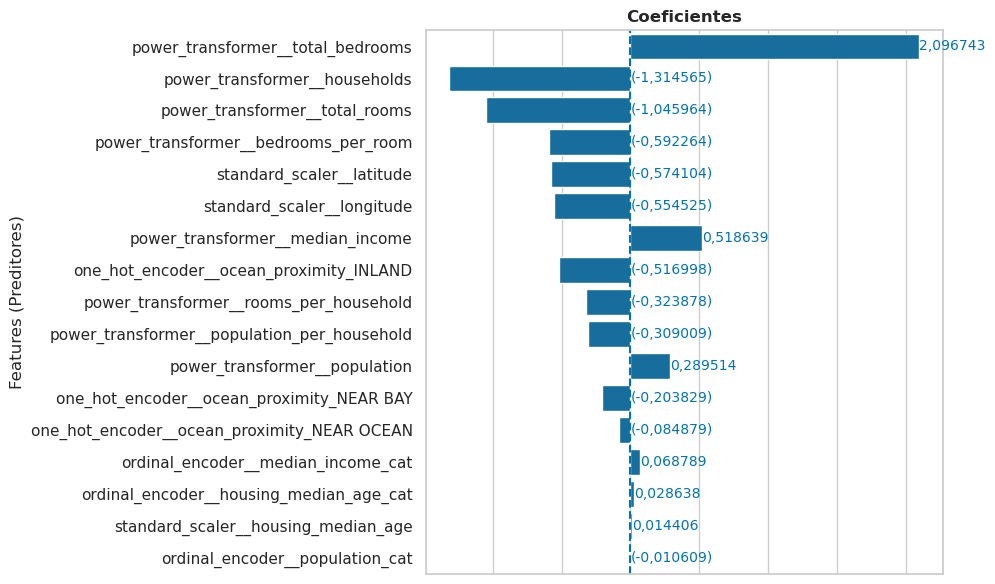

In [13]:
plot_coeficientes(df_coeficientes.T, precisao=6,)

Podemos ver que as features de 'longitude' e 'latitude', agora padronizadas/transformadas, continuam bastante relevantes, o que faz sentido para o negócio, uma vez que se trata de localiação dos imóveis.
- Compararando com a etapa anterior, podemos ver que a transformação das variáveis foi capaz de trocar bastante a relevância das variáveis para o modelo, trocando bastante sua ordem.

Todas as features tiveram alguma contribuição para o novo modelo, mesmo que algumas tiveram um coeficiente bem pequeno.

## Vamos comparar nosso novo melhor modelo com os que tinhamos antes

In [14]:
# regressores atualizado com a melhor estratégia encontrada pelo GRID SEARCH
# apenas para comparar com o melhor modelo que sairá do grid search
regressors = {
    # Modelo incial simples apenas para comparação
    'LinearRegression_simples': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },

    # melhor até o momento,
    'LinearRegression_melhor_atual': {
        'preprocessor': preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal')
    },

    # novo modelo indicado como melhor após o GRID SEARCH
    'LinearRegression_best_estimator': {
        'preprocessor':       grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor':          grid_search.best_estimator_.regressor_['regressor'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    }
}

pprint(regressors)

{'LinearRegression_best_estimator': {'preprocessor': ColumnTransformer(transformers=[('one_hot_encoder', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat', 'housing_median_age_cat',
                                  'population_cat']),
                                ('standard_scaler', StandardScaler(),
                                 ['longitude', 'latitude',
                                  'housing_median_age']),
                                ('power_transformer',
                                 PowerTransformer(method='box-cox'),
                                 ['bedrooms_per_room', 'households',
                                  'median_income', 'population',
                                  'population_per_household',
                                  'rooms_per_household', 'total_bedrooms',
                         

In [15]:
df_resultados = fnc_treinar_e_validar_modelos_regressao(
    X=X_train,
    y=y_train,
    regressors=regressors,
    scoring=tuple(dct_metricas_modelos.keys()),
)

fnc_exibir_dataframe_resultados(df_resultados)

Index(['model', 'fit_time', 'score_time', 'test_neg_mean_absolute_error',
       'test_neg_root_mean_squared_error', 'test_r2', 'time_seconds'],
      dtype='object')


,model,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
0,LinearRegression_simples,0.027268,0.013251,-40752.245328,-55293.325335,0.649683,0.040519
1,LinearRegression_simples,0.025297,0.012904,-43153.132860,-65273.979368,0.537121,0.038201
2,LinearRegression_simples,0.025779,0.013569,-42344.177226,-58983.680481,0.625750,0.039348
3,LinearRegression_simples,0.026834,0.012911,-42839.980813,-58944.889944,0.635304,0.039745
4,LinearRegression_simples,0.028551,0.014657,-42373.880720,-58053.346421,0.625479,0.043208
5,LinearRegression_melhor_atual,0.037055,0.015643,-38953.324853,-54310.273467,0.662028,0.052698
6,LinearRegression_melhor_atual,0.037192,0.015769,-40702.947625,-58424.162111,0.629173,0.052961
7,LinearRegression_melhor_atual,0.037491,0.015979,-40041.008457,-55874.597722,0.664164,0.053471
8,LinearRegression_melhor_atual,0.035749,0.015649,-41138.716246,-58978.678970,0.634885,0.051398
9,LinearRegression_melhor_atual,0.035233,0.015635,-40829.097988,-57809.044249,0.628625,0.050867


In [16]:
fnc_exibir_dataframe_resultados(df_resultados.groupby('model').mean())

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
model,,,,,,
LinearRegression_best_estimator,1.184181,0.018092,-39125.939510,-55211.911197,0.666665,1.202273
LinearRegression_melhor_atual,0.036544,0.015735,-40333.019034,-57079.351304,0.643775,0.052279
LinearRegression_simples,0.026746,0.013458,-42292.683389,-59309.844310,0.614667,0.040204


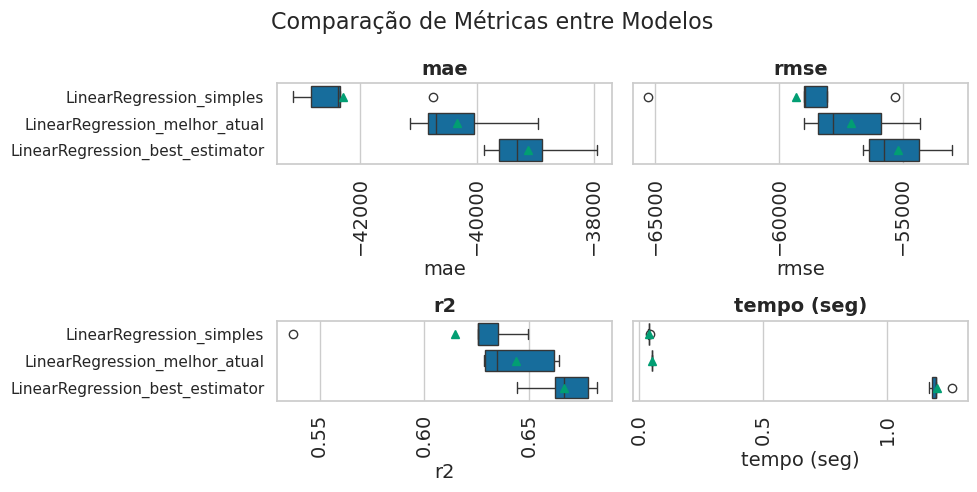

In [17]:
plot_comparar_metricas_modelos(
    df_resultados=df_resultados,
    comparar_metricas=['test_' + metrica for metrica in dct_metricas_modelos.keys()] + ['time_seconds'],
    nomes_metricas=list(dct_metricas_modelos.values()) + ['tempo (seg)'],
    figsize=(10, 5),
    colunas_graficos=2,
    flg_boxplots_horizontais=True,
)

### Sobre o novo modelo encontrado pelo GRID SEARCH
- O novo modelo encontrado pelo GRID SEARCH consegue vencer o nosso melhor modelo até então em todas as métricas de avaliação selecionadas. Média e mediana claramente superiores ao modelo anterior.
- O tempo dos pré-processamento ficou distante, mas para nosso volume de dados não é relevante para desqualificar o novo modelo.
- Vamos considerar esse novo modelo como substituto do `LinearRegression_melhor_atual` que não fazia pré-processamento de colunas numericas.

Novas análises ainda serão feitas nas próximas etapas. Ainda ainda podemos testar features polinomiais e regularizações.

Vamos analisar resíduos para comparar com as etapas anterior e posteriores.

## Resíduos do modelo novo

### Resíduos sobre a base de teste
Essa base não participou do treinamento em nenhum momento e são novos para o modelo.

In [18]:
# dados já separados como X e y de teste
X_test = pd.read_parquet(DADOS_X_TEST)
y_test = pd.read_parquet(DADOS_Y_TEST)

print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)

X_test.shape (3639, 15)
y_test.shape (3639, 1)


In [19]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_test - grid_search.predict(X_test)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.13/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,0.69
kurtosis,3.08


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-326815.830442,-111237.114138,-132407.616290,-27776.652344,-3978.647461,27863.655152,181188.392107,111324.117188,329175.004054,3311.067871,56527.164062


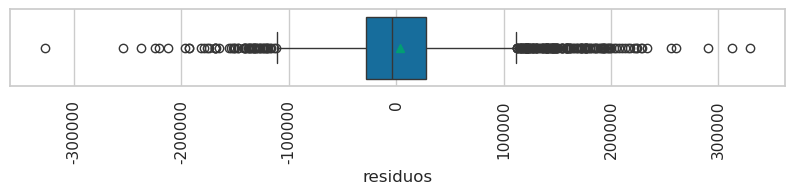

In [20]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

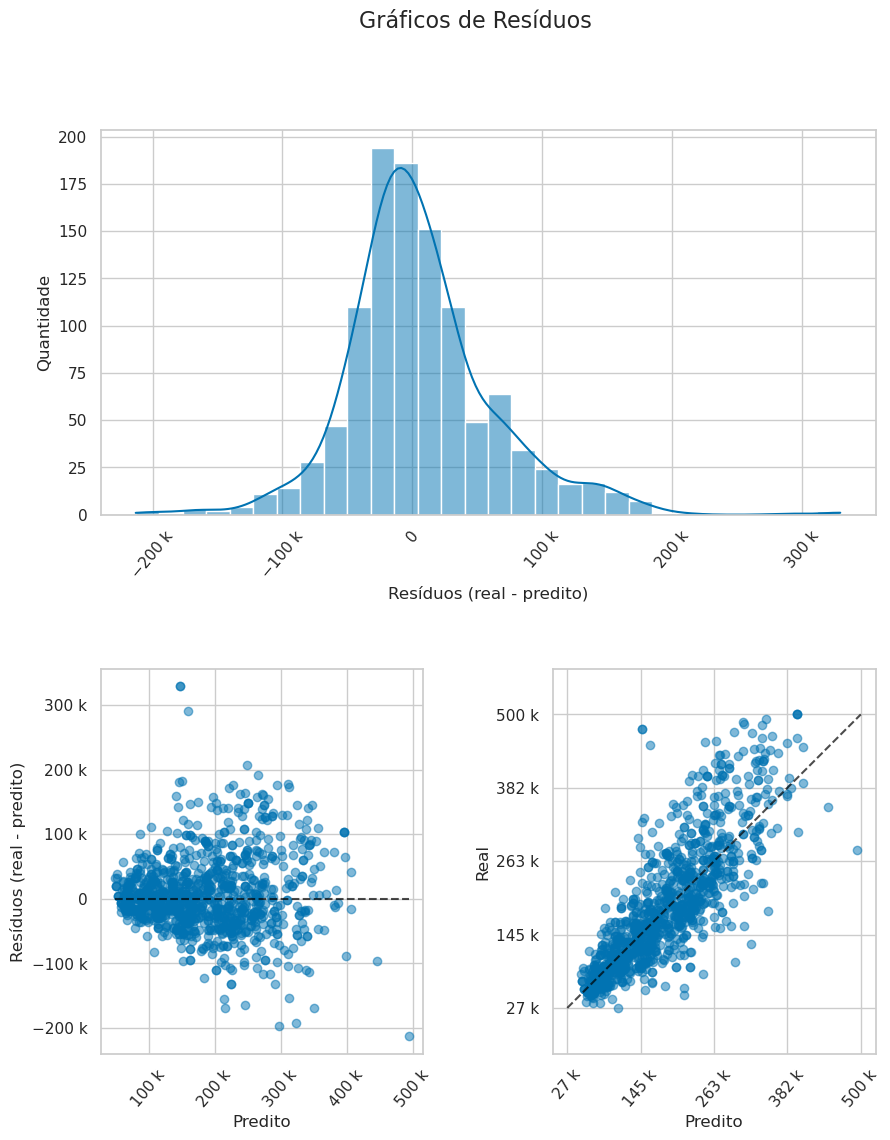

In [21]:
plot_residuos_estimador(grid_search.best_estimator_, X_test, y_test, fracao_amostra=0.3, eng_formatter=True) #, mosaico='bc;aa')

### Resíduos sobre a base de validação
Essa base não participou do treinamento em nenhum momento e são novos para o modelo.

In [22]:
y_validation = pd.read_parquet(DADOS_Y_VALIDATION)
X_validation = pd.read_parquet(DADOS_X_VALIDATION)

print('X_validation.shape', X_validation.shape)
print('y_validation.shape', y_validation.shape)

X_validation.shape (1874, 15)
y_validation.shape (1874, 1)


In [23]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_validation - grid_search.predict(X_validation)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.13/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,0.94
kurtosis,4.35


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-311842.563771,-111854.735694,-118706.544080,-27705.859375,-3267.641113,28393.391724,188853.800078,112542.268174,362500,4209.535156,58011.468750


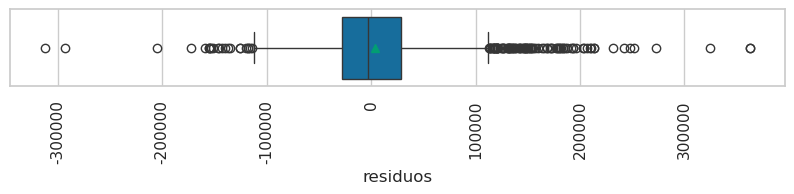

In [24]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

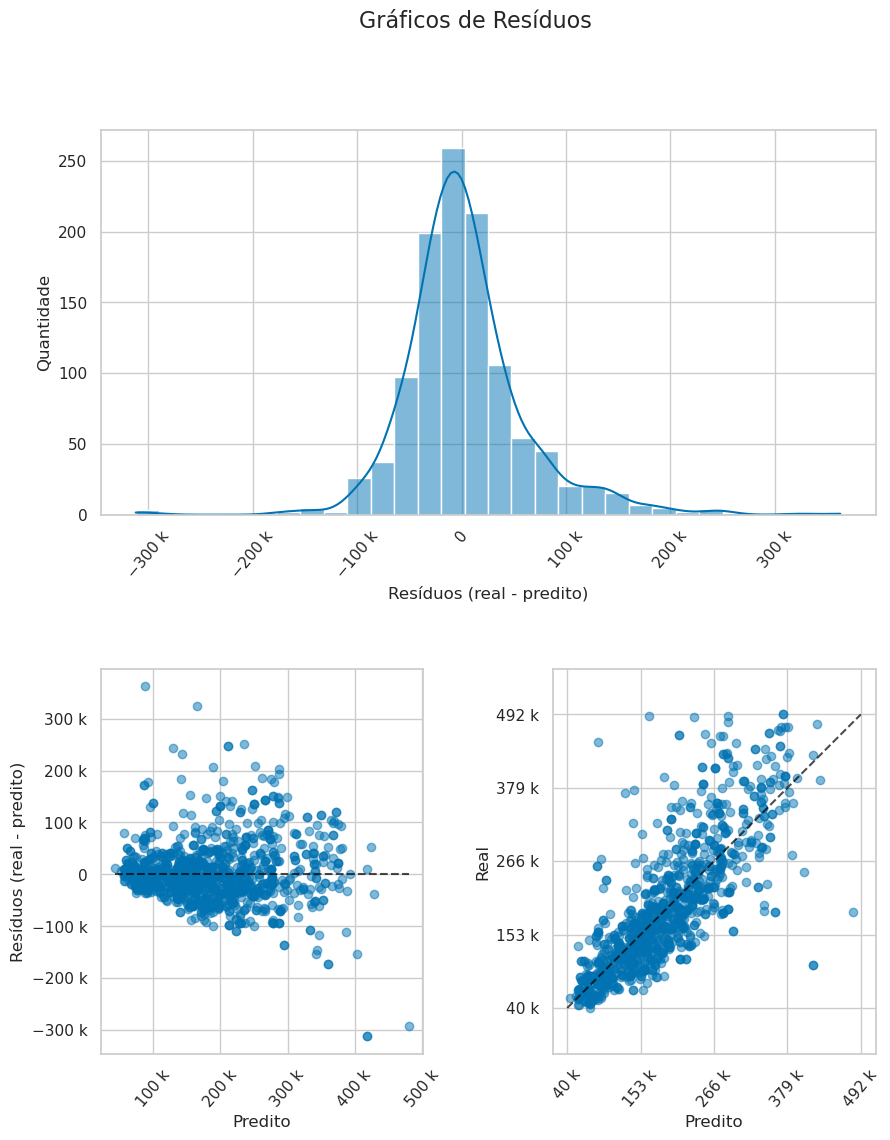

In [25]:
plot_residuos_estimador(grid_search.best_estimator_, X_validation, y_validation, fracao_amostra=0.6, eng_formatter=True) #, mosaico='bc;aa')

### Analisando os dados e gráficos de resíduos
Não podemos notar muita diferença entre nossos novos gráficos e os gráficos da etapa anterior.
Não temos indicio de overfiting, teste e validação mostram comportamento semelhantes.